# 19. 텍스트 요약(Text Summarization)

## 1) 어텐션을 이용한 텍스트 요약(Text Summarization with Attention mechanism)

텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것을 말합니다. 

이번 실습에서는 그 중 한 가지 방법인 seq2seq를 구현해보겠습니다. 그리고 어텐션 메커니즘(attention mechanism)을 적용해봅시다.

### 1. 텍스트 요약(Text Summarization)

#### 1) 추출적 요약(extractive summarization)

추출적 요약은 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법입니다.

#### 2) 추상적 요약(abstractive summarization)

추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법입니다.

### 2. 아마존 리뷰 데이터에 대한 이해

https://www.kaggle.com/snap/amazon-fine-food-reviews

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

#### 1) 데이터 로드하기

In [2]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 
# 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("datasets/Reviews.csv", nrows=100000)
print('전체 리뷰 개수 :', len(data))

전체 리뷰 개수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


#### 2) 데이터 정제하기

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


전체 데이터는 10만개의 샘플이 존재하지만, 실제로는 꽤 많은 원문이 중복되어 중복을 배제한 유일한 원문의 개수는 88,426개입니다. 중복 샘플이 무려 약 1,200개나 있다는 의미지요. Summary는 중복이 더 많지만, 원문은 다르더라도 짧은 문장인 요약은 내용이 겹칠 수 있음을 가정하고 일단 두겠습니다.

In [6]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 88426


In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 88425


동일한 의미를 가졌지만 스펠링이 다른 단어들을 정규화하기 위한 사전을 만듭니다. 이 사전은 아래의 링크를 참고하여 만들어진 사전입니다.

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [9]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

NLTK의 불용어를 저장하고 개수를 확인해봅시다.

In [10]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'been', 'but', 'i', 'they', 'this', 'doing', 'wasn', 'those', 'our', 'just', 'didn', 'during', 'shan', "haven't", 'couldn', 'his', 'and', "shouldn't", 'doesn', 'isn', 'ours', 'hadn', 'himself', 'at', 'theirs', "hasn't", 'over', "that'll", 'so', 'with', 'has', 'whom', 'that', "didn't", "you've", 'should', 'll', 'below', 'all', 'here', 'under', "you're", 'each', 'of', 'when', "she's", 'itself', 'off', 'into', 'than', 'aren', 'how', 'before', 'too', 'only', "you'll", 'm', 'needn', 'in', 'because', 'yourself', 'she', 'do', 'for', 'down', 'own', 've', 'won', "mightn't", 'or', 'after', "hadn't", 'you', 'both', 'on', 'herself', 'not', 'ain', 'had', 'ourselves', 'such', 'other', 'will', 'haven', 'who', 'no', 'more', 'have', 're', 'now', 'yours', 'the', 'yourselves', 'o', 'while', 'don', 'having', 'be', 'does', 'then', 'few', 'some', 'wouldn', 'above', "you'd", "isn't", 'your', 'from', 'if', 'ma', 'up', 'is', 'hasn', 'did', 'again', 'once', 'any', 'd', "needn't", "mustn't", 'furth

전처리 함수를 설계합니다.

여기서는 Text 열에서는 불용어를 제거하고, Summary 열에서는 불용어를 제거하지 않기로 결정했습니다. Summary를 입력으로 할 때는 두번째 인자를 0으로 줘서 불용어를 제거하지 않는 버전을 실행하겠습니다.

In [11]:
def preprocess_sentence(sentence, remove_stopwords=True):
    # 텍스트 소문자화
    sentence = sentence.lower()
    
    # <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    
    # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    
    # 쌍따옴표 " 제거
    sentence = re.sub('"','', sentence)
    
    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    
    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b","",sentence)
    
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    
    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

우선 Text 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 3개의 전처리 된 샘플을 출력합니다.

In [12]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:3]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch']

이제 Summary 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 3개의 전처리 된 샘플을 출력합니다.

In [13]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:3]

C:\Users\seungwon\anaconda3\envs\scratch\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\seungwon\anaconda3\envs\scratch\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food', 'not as advertised', 'delight says it all']

전처리 후의 결과를 다시 데이터프레임에 저장합니다.

In [14]:
data['Text'] = clean_text
data['Summary'] = clean_summary

혹시 전처리 과정에서 빈 값이 생겼다면 Null 값으로 변경한 후에 Null 값을 가진 샘플이 생겼는지 확인합니다.

In [15]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 88355


이제 Text 열과 Summary 열에 대해서 길이 분포를 확인해보겠습니다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


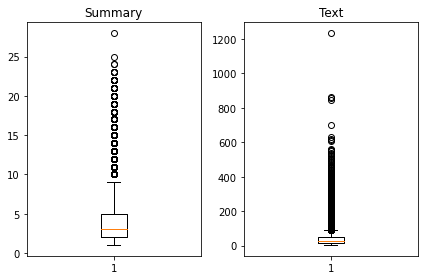

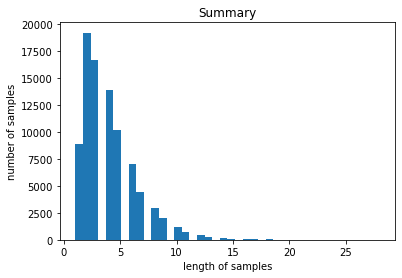

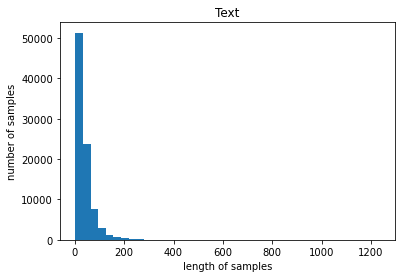

In [17]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

원문 텍스트는 대체적으로 100이하의 길이를 가집니다. 또한, 평균 길이는 38입니다. 요약의 경우에는 대체적으로 15이하의 길이를 가지며 평균 길이는 4입니다. 

여기서 패딩의 길이를 정하겠습니다. 평균 길이보다는 크게 잡아 각각 50과 8로 결정합니다.

In [18]:
text_max_len = 50
summary_max_len = 8

In [19]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', len(data))

전체 샘플수 : 65818


seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다. 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 명명하고 앞, 뒤로 추가하겠습니다.

In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


인코더의 입력, 디코더의 입력과 레이블을 각각 저장해줍니다.

In [21]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

#### 3) 데이터의 분리

우선, 순서가 섞인 정수 시퀀스를 만들어줍니다.

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[29546 43316 24839 ... 45891 42613 43567]


이 정수 시퀀스 순서를 데이터의 샘플 순서로 정의해주면 샘플의 순서는 섞이게 됩니다.

In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해주겠습니다.

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [26]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


#### 4) 정수 인코딩

훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다. 여기서는 단어 집합의 크기를 8000으로 제한하겠습니다.

In [27]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

이제 레이블에 해당하는 요약 데이터에 대해서도 수행하겠습니다.

In [28]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#### 5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미합니다. 

길이가 0이 된 요약문의 실질적 길이는 1입니다. decoder_input에는 sostoken, decoder_target에는 eostoken만 남았을 것이기 때문입니다.

요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 저장하여 삭제합니다.

In [29]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [30]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 51420
훈련 레이블의 개수 : 51420
테스트 데이터의 개수 : 12826
테스트 레이블의 개수 : 12826


C:\Users\seungwon\anaconda3\envs\scratch\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 6) 패딩하기

In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### 3. seq2seq + attention으로 요약 모델 설계 및 훈련시키기

In [32]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

인코더를 설계해보겠습니다. 인코더는 LSTM 층을 3개 쌓습니다.

In [33]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, 
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, 
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, 
                     dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더를 설계해보겠습니다. 

단, 출력층은 제외하고 설계하겠습니다. 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태(initial_state)를 인코더의 상태로 주어야 하는 것에 주의합시다.

In [34]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, 
                    dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

이제 디코더의 출력층을 설계합니다.

In [35]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

이번 챕터에서는 어텐션 메커니즘을 사용할 예정이므로 위에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계해보겠습니다.

어텐션 함수를 직접 작성하지 않고 이미 저자의 깃허브에 작성된 어텐션을 사용할 것이므로 아래의 코드를 통해 attention.py 파일을 다운로드하고, AttentionLayer를 임포트합니다. (바다나우 어텐션입니다.)

In [36]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/19.%20Text%20Summarization/attention.py", 
#                            filename="attention.py")
from attention import AttentionLayer

어텐션 메커니즘을 이용해 디코더의 출력층을 새롭게 설계합니다.

In [37]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x=[encoder_input_train, decoder_input_train], 
                    y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
201/201 [==============================] - 283s 1s/step - loss: 2.6961 - val_loss: 2.4611
Epoch 2/50
201/201 [==============================] - 309s 2s/step - loss: 2.3820 - val_loss: 2.3024
Epoch 3/50
201/201 [==============================] - 368s 2s/step - loss: 2.2338 - val_loss: 2.1556
Epoch 4/50
201/201 [==============================] - 359s 2s/step - loss: 2.1106 - val_loss: 2.0744
Epoch 5/50
201/201 [==============================] - 360s 2s/step - loss: 2.0257 - val_loss: 2.0173
Epoch 6/50
201/201 [==============================] - 360s 2s/step - loss: 1.9618 - val_loss: 1.9749
Epoch 7/50
201/201 [==============================] - 352s 2s/step - loss: 1.9107 - val_loss: 1.9476
Epoch 8/50
201/201 [==============================] - 338s 2s/step - loss: 1.8661 - val_loss: 1.9248
Epoch 9/50
201/201 [==============================] - 284s 1s/step - loss: 1.8260 - val_loss: 1.9061
Epoch 10/50
201/201 [==============================] - 282s 1s/step - loss: 1.7904 - val_lo

학습 과정하면서 기록된 훈련 데이터의 손실과 테스트 데이터의 손실 히스토리를 시각화하여 출력합니다

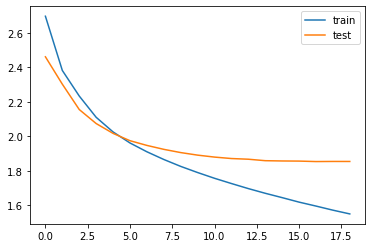

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 4. seq2seq + attention으로 요약 모델 테스트하기

테스트를 위해 필요한 3개의 사전을 만듭니다.

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있습니다. 다시 새로운 seq2seq 모델을 만들겠습니다. 

우선 인코더를 정의합니다.

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[encoder_outputs, state_h, state_c])

이제 테스트 단계의 디코더를 설계합니다.

In [43]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=[decoder_state_input_h, decoder_state_input_c])
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

테스트를 위해 사용되는 함수 decode_sequence를 설계합니다.

In [44]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

테스트 단계에서 원문과 실제 요약문, 예측 요약문을 비교하기 위해 정수 시퀀스를 텍스트 시퀀스로 만드는 함수를 설계합니다.

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [46]:
test_i = 500
for i in range(test_i, test_i+4):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  disappointing purchase two packages opened noodles fell apart many tiny pieces water bought noodles never happen guessing damage shipping 
실제 요약문 : in the water 
예측 요약문 :  pumpkin


원문 :  product along lines hamburger helper remember eating kid wanted try product liquid gold orzo pasta nice treat broccoli joke small little freeze dried broccoli cheese sauce strong smell mixed rest ingredients lost taste loved overall okay nothing special better making scratch 
실제 요약문 : kraft chicken and broccoli dinner kit 
예측 요약문 :  not for me


원문 :  tried many kinds coffee keep coming back newman love ordering amazon coffee right door cannot beat 
실제 요약문 : best coffee in 
예측 요약문 :  great coffee


원문 :  healthy tasty portable packets great go perfect gym bag cannot around fresh next best option pear mango flavor texture smooth applesauce recently packed work trip good way add little something healthy hotel fast food often dominate comes business travel 
실제 요약문 : great snack for adults 
예측 요약문 :